# Data Preparation

In [39]:
import os 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from ipynb.fs.full.Utils import loadDataFrames

In [40]:
def deleteOutliersByField(df, field):
    iqr = 1.5 * (np.percentile(df[field], 75)) - (np.percentile(df[field], 25))
    greaterThan75 = df[df[field] > (iqr + np.percentile(df[field], 75))]
    print('amount of rows to delete greater than 75' , len(greaterThan75))
    lesserThan25 = df[df[field] < (np.percentile(df[field], 25) - iqr )]
    print('amount of rows to delete lesser than 25' , len(lesserThan25))
    df.drop(greaterThan75.index, inplace = True)
    df.drop(lesserThan25.index, inplace = True)
    
def printNewShapeDF(df):
    print('::: New Shape Dataframe', df.shape)
    
def getRenameObject(enc, columnNames):
    encodedFeaturesNames = enc.get_feature_names_out(columnNames)
    columns = {}
    for i in range(0,len(encodedFeaturesNames)):
        columns[i] = encodedFeaturesNames[i]
    return columns, encodedFeaturesNames


## -0.000999, 0.000186]    1
## (0.000186, 0.985]       2
##  0 = 0

def getInstrumentalnessCat(row):
    inst = row.instrumentalness
    if inst == 0:
        val = 0
    elif inst >= -0.000999 and inst < 0.000186:
        val = 1
    else:
        val = 2
    return val

In [41]:
spotifyFeatures, transitionMatrices, df = loadDataFrames()

In [42]:
columnName = 'speechiness'
numOfUniqueValues = len(df[columnName].value_counts())
print( 'fraction of unique values over the sample size', numOfUniqueValues / len(df) )
print( 'The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large', numOfUniqueValues / len(df) )

fraction of unique values over the sample size 0.1528683726375648
The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large 0.1528683726375648


## Rule of thumb from book applied predictive modeling related to variance

- The fraction of unique values over the sample size is low (say 10 %).
- The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20).


If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.


## Cleaning Data

In [43]:
print('spotifyFeatures len :', len(spotifyFeatures))
print('transitionMatrices len :', len(transitionMatrices))

spotifyFeatures len : 5992
transitionMatrices len : 5980


In [44]:
df[df.duplicated(subset=['id_track'])]

,id,id_spotify_track,id_track,danceability,energy,key,loudness,mode,speechiness,acousticness,...,1284,1286,1287,1288,1290,1291,1292,1293,1294,1295


In [45]:
len(df.columns.tolist())

1058

In [46]:
s = df.nunique(axis=0)
s[s < 15].index

Index(['key', 'mode', 'time_signature', 'mood', '8', '10', '13', '17', '19',
       '23',
       ...
       '1276', '1279', '1280', '1282', '1284', '1290', '1291', '1293', '1294',
       '1295'],
      dtype='object', length=549)

In [47]:
spotifyFeatures.columns

Index(['id_spotify_track', 'id_track', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity', 'album_name', 'release_date', 'mood'],
      dtype='object')

## Removing useless columns

In [48]:
df = df.drop(['id_spotify_track', 'id_track', 'popularity', 'duration_ms', 'release_date', 'name', 'album_name'], axis=1)

In [49]:
df.head()

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,1284,1286,1287,1288,1290,1291,1292,1293,1294,1295
0,23,0.494,0.756,7,-8.504,1,0.0432,0.001400,0.005200,0.1640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,105,0.582,0.744,7,-9.155,1,0.0336,0.000458,0.001320,0.0405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,118,0.614,0.755,2,-5.829,1,0.0276,0.016200,0.000002,0.0831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,120,0.319,0.807,11,-6.504,0,0.0388,0.001040,0.290000,0.1310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292,0.496,0.527,6,-7.234,1,0.0339,0.195000,0.000000,0.1380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking Skewness [here](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#:~:text=If%20the%20skewness%20is%20between,the%20data%20are%20highly%20skewed)

<font color="blue"> 
Analyzing the skewness of the continous variables it is found that:
</font>

    
Fairly Simetrical (-0.5, 0.5):
- danceability
- energy
- valence
- tempo
    
Moderately skewed (-1, 0.5) or (0.5, 1)
- acousticness

Highely skewed less than -1 or greater than 1
- instrumentalness
- liveness
- speechiness
- loudness

In [50]:
continousVariables = ['loudness', 'danceability','energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [51]:
df[continousVariables].skew(axis = 0, skipna = True)

loudness           -1.430149
danceability       -0.222107
energy             -0.359300
speechiness         4.312946
acousticness        0.687379
instrumentalness    3.365741
liveness            2.461755
valence             0.163496
tempo               0.429819
dtype: float64

### Check columns with low variance

In [52]:
spotifyFeatures.var()

id_track            1.967998e+13
danceability        2.523056e-02
energy              5.266206e-02
key                 1.253987e+01
loudness            1.555073e+01
mode                2.095932e-01
speechiness         2.988320e-03
acousticness        9.763417e-02
instrumentalness    4.297431e-02
liveness            2.961088e-02
valence             5.882719e-02
tempo               8.774343e+02
duration_ms         5.206068e+09
time_signature      1.135787e-01
popularity          3.431477e+02
mood                9.774175e+00
dtype: float64

# (?) Check whether its better to apply outliers techniques, although this logic is being infered from descriptions and data

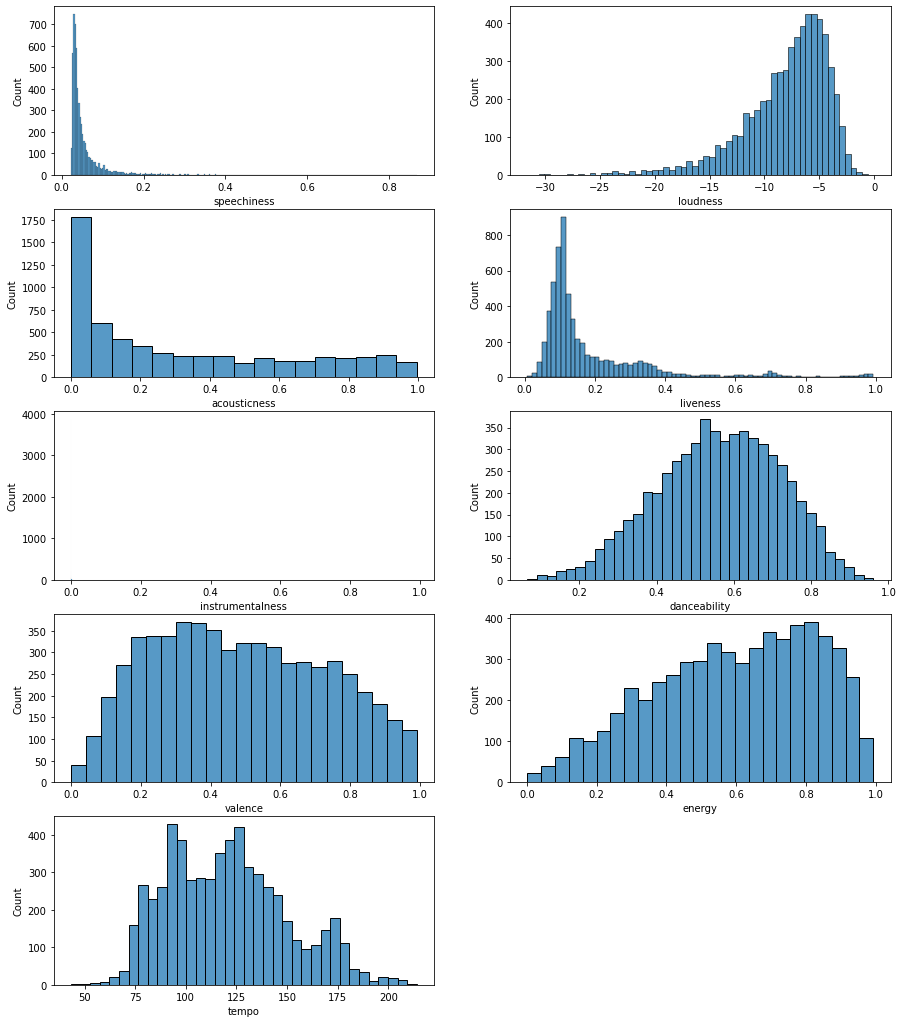

In [53]:
plt.figure(figsize=(15,18))

numRows = 5
numColumns = 2

plt.subplot(numRows, numColumns, 1); 
sns.histplot(df['speechiness'])

plt.subplot(numRows,numColumns,2)
sns.histplot(df['loudness'])

plt.subplot(numRows, numColumns, 3);
sns.histplot(df['acousticness'])

plt.subplot(numRows, numColumns, 4);
sns.histplot(df['liveness'])

plt.subplot(numRows, numColumns, 5);
sns.histplot(df['instrumentalness'])

plt.subplot(numRows, numColumns, 6); 
sns.histplot(df['danceability'])

plt.subplot(numRows, numColumns, 7); 
sns.histplot(df['valence'])

plt.subplot(numRows, numColumns, 8); 
sns.histplot(df['energy'])

plt.subplot(numRows, numColumns, 9); 
sns.histplot(df['tempo'])


plt.show()

<AxesSubplot:xlabel='tempo', ylabel='Density'>

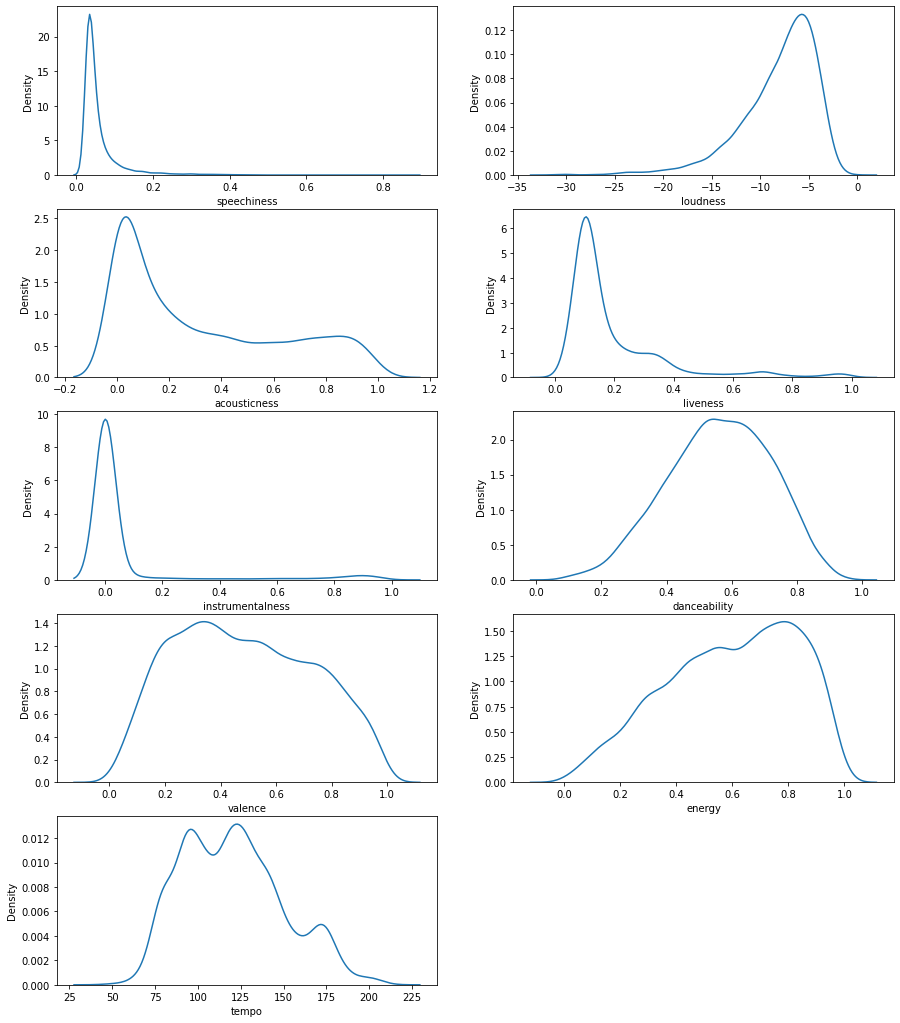

In [54]:
plt.figure(figsize=(15,18))

numRows = 5
numColumns = 2

plt.subplot(numRows, numColumns, 1); 
sns.kdeplot(data=df, x="speechiness")

plt.subplot(numRows, numColumns,2)
sns.kdeplot(data=df, x="loudness")

plt.subplot(numRows, numColumns, 3);
sns.kdeplot(data=df, x="acousticness")

plt.subplot(numRows, numColumns, 4);
sns.kdeplot(data=df, x="liveness")

plt.subplot(numRows, numColumns,5);
sns.kdeplot(data=df, x="instrumentalness")

plt.subplot(numRows, numColumns, 6); 
sns.kdeplot(df['danceability'])

plt.subplot(numRows, numColumns, 7); 
sns.kdeplot(df['valence'])

plt.subplot(numRows, numColumns, 8); 
sns.kdeplot(df['energy'])

plt.subplot(numRows, numColumns, 9); 
sns.kdeplot(df['tempo'])



## Speechiness

One way to do it would be to rely merely on the data understanding too.
df = df.loc[df.speechiness <= 0.33]

<font color="blue"> 
    
It was found there was not a high representation for tracks with speech-like tracks, only 18 register fit under this category. Therefore an outlier treatment was applied for this case. The skewness went from highly to moderate.
</font>

In [55]:
df.speechiness.describe()

count    5979.000000
mean        0.058277
std         0.054365
min         0.022400
25%         0.031800
50%         0.039700
75%         0.059600
max         0.867000
Name: speechiness, dtype: float64

In [56]:
len(df.loc[df.speechiness > 0.33][['speechiness']])

51

### Checking Variance

In [57]:
print(df.speechiness.var())

0.002955545840969209


In [58]:
df.speechiness.value_counts()

0.0278    38
0.0296    35
0.0299    32
0.0324    32
0.0286    32
          ..
0.0997     1
0.0923     1
0.0908     1
0.0879     1
0.1960     1
Name: speechiness, Length: 914, dtype: int64

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


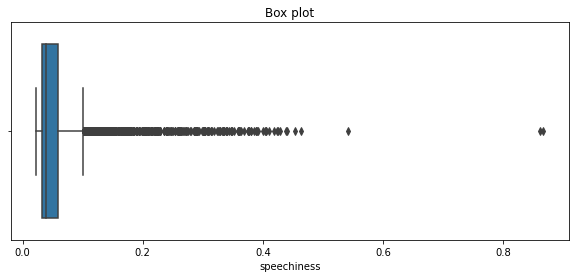

In [59]:

plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

<Figure size 720x288 with 0 Axes>

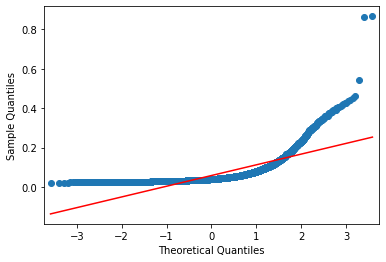

In [60]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.speechiness, line='s')
plt.show()

In [65]:
totalRows = len(df.speechiness)
range1 = len(df.speechiness[df.speechiness <= 0.33])
range2 = len(df.speechiness.loc[(df.speechiness >= 0.33) & (df.speechiness < 0.66)])
range3 = len(df.speechiness.loc[(df.speechiness >= 0.66)])


print('less than 0.33          | ', range1/totalRows , str(round(range1, 2)) )
print('btw than 0.33 and 0.66  | ', range2/totalRows , str(round(range2, 2)))
print('over than 0.5           | ', range3/totalRows, str(round(range3, 2)))

less than 0.33          |  0.9914701455092825 5928
btw than 0.33 and 0.66  |  0.008195350393042315 49
over than 0.5           |  0.0003345040976751965 2


In [63]:
range2

2

In [64]:
df.loc[df.speechiness > 0.66]

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,1284,1286,1287,1288,1290,1291,1292,1293,1294,1295
2123,1045577,0.553,0.521,2,-15.263,1,0.861,0.663,0.000000,0.193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4313,6000827,0.673,0.285,5,-14.143,1,0.867,0.750,0.000003,0.693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font color="blue"> 
As it can be seen data is not falling into the red reference line what means that data is not normally distributed
</font>

In [67]:
df = df.loc[df.speechiness <= 0.66]
printNewShapeDF(df)

::: New Shape Dataframe (5977, 1051)


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


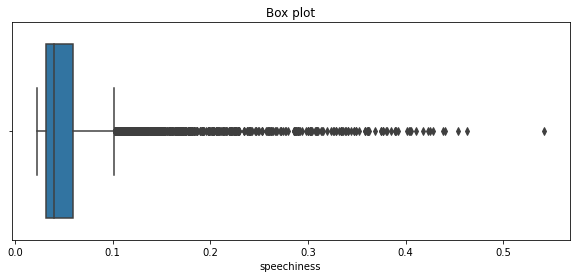

In [68]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

In [70]:
totalRows = len(df.speechiness)
range1 = len(df.speechiness[df.speechiness <= 0.33])
range2 = len(df.speechiness.loc[(df.speechiness > 0.33) & (df.speechiness <= 0.66)])
range3 = len(df.speechiness.loc[(df.speechiness > 0.66)])


print('less than 0.33          | ', range1/totalRows , str(round(range1, 2)) )
print('btw than 0.33 and 0.66  | ', range2/totalRows , str(round(range2, 2)))
print('over than 0.5           | ', range3/totalRows, str(round(range3, 2)))

less than 0.33          |  0.9918019073113602 5928
btw than 0.33 and 0.66  |  0.008198092688639786 49
over than 0.5           |  0.0 0


<Figure size 720x288 with 0 Axes>

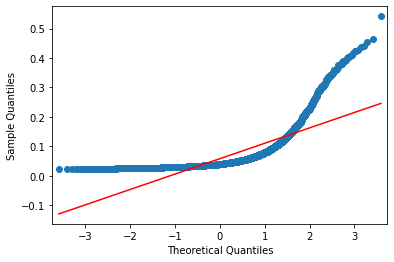

In [71]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.speechiness, line='s')
plt.show()

***After removing outliers the skewness of speechiness improved significantly, now it is moderate***

In [72]:
df[['speechiness']].skew(axis = 0, skipna = True)

speechiness    3.629431
dtype: float64

In [73]:
print(df.speechiness.var())

0.002739193905067036


## Instrumentalness highly skewed

https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
    https://towardsdatascience.com/avoid-mistakes-in-machine-learning-models-with-skewed-count-data-e3512b94d745

<font color="blue"> 
Instrumentalness is a valuable feature because it determines how much vocal a song includes, however it contains continous features and it is highly skewed, so we're going to check whether binning here makes more sense.
</font>

In [74]:
df.instrumentalness.describe()

count    5977.000000
mean        0.064396
std         0.205025
min         0.000000
25%         0.000000
50%         0.000009
75%         0.001240
max         0.990000
Name: instrumentalness, dtype: float64

In [76]:
totalRows = len(df.instrumentalness)
range1 = len(df.instrumentalness[df.instrumentalness < 0.5])
range2 = len(df.instrumentalness[df.instrumentalness > 0.5])
print('less than 0.5', range1/totalRows , range1)
print('over than 0.5', range2/totalRows, range2)

less than 0.5 0.935419106575205 5591
over than 0.5 0.06458089342479505 386


<Figure size 720x288 with 0 Axes>

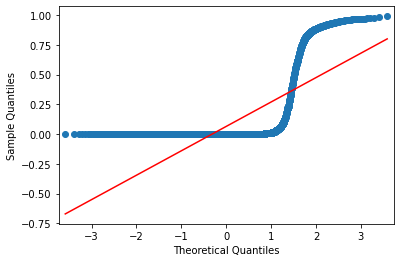

In [77]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.instrumentalness, line='s')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


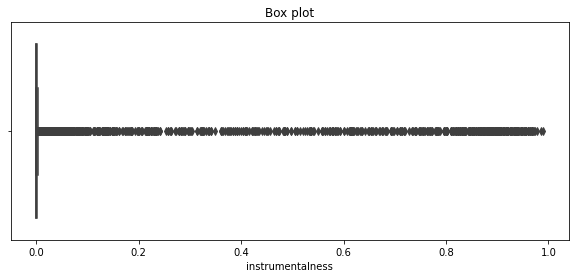

In [78]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.instrumentalness)
plt.show()

<font color="blue"> 
    Since Values below 0.5 represent almost the 98% or observations a binning approach has been decided, since logarithm approach was not appropiate in this case
</font>

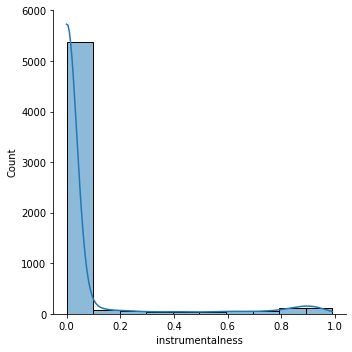

In [79]:
sns.displot(data=df, x="instrumentalness", kde=True, bins=10)

**The following bins were created**

In [80]:
df.instrumentalness.value_counts()

0.000000    2325
0.000105       9
0.000001       7
0.001090       7
0.000001       6
            ... 
0.157000       1
0.009520       1
0.000016       1
0.000044       1
0.169000       1
Name: instrumentalness, Length: 2287, dtype: int64

<font color="blue"> 
Binning using quantiles a total of 3 categories were created
</font>

In [81]:

df['instrumentalness_cat'] = df.apply(getInstrumentalnessCat, axis=1)

In [82]:
df['instrumentalness_cat'].value_counts()

0    2325
2    2015
1    1637
Name: instrumentalness_cat, dtype: int64

***Dropping the previous instrumentalness column**

In [83]:
df = df.drop(['instrumentalness'], axis=1)

## Liveness

In [84]:
df.liveness.describe()

count    5977.000000
mean        0.190890
std         0.172113
min         0.007860
25%         0.095300
50%         0.120000
75%         0.221000
max         0.993000
Name: liveness, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


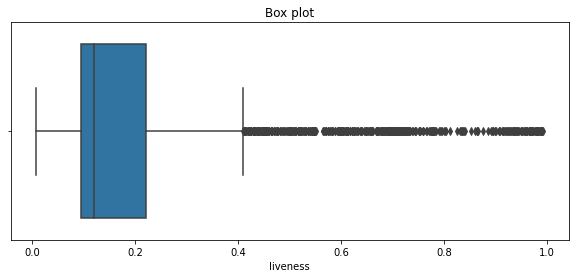

In [85]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.liveness)
plt.show()

## Hot Encoding Categorical features

In [86]:
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'liveness', 'valence',
       ...
       '1286', '1287', '1288', '1290', '1291', '1292', '1293', '1294', '1295',
       'instrumentalness_cat'],
      dtype='object', length=1051)

In [87]:
# changing types 
categoricalFeatures = ['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat']
df = df.astype({"key": int,"time_signature": int, "mode": int, "mood": int })

<AxesSubplot:xlabel='instrumentalness_cat', ylabel='Count'>

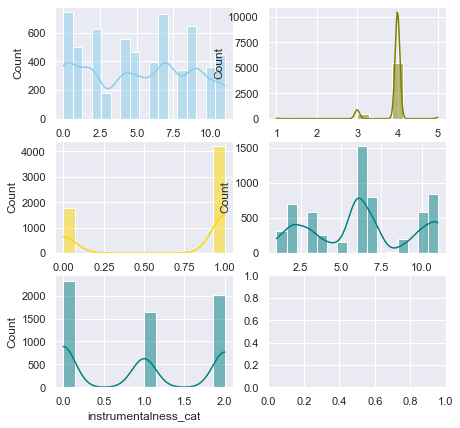

In [88]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 2, figsize=(7, 7))

sns.histplot(data=df, x="key", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="time_signature", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="mode", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="mood", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df, x="instrumentalness_cat", kde=True, color="teal", ax=axs[2, 0])

#### Joining time signatures into two categories

In [89]:
df.time_signature.value_counts()

4    5441
3     451
5      63
1      22
Name: time_signature, dtype: int64

In [90]:
df.time_signature = df.apply(lambda x : 1 if x.time_signature == 4 else 0, axis=1)

In [91]:
df.time_signature.value_counts()

1    5441
0     536
Name: time_signature, dtype: int64

### Hot encoding

In [92]:
categDF = df[categoricalFeatures]

In [93]:
categDF

,key,time_signature,mode,mood,instrumentalness_cat
0,7,1,1,7,2
1,7,1,1,10,2
2,2,1,1,7,1
3,11,1,0,7,2
4,6,1,1,3,0
...,...,...,...,...,...
5974,5,1,1,3,1
5975,1,1,0,10,2
5976,1,0,1,7,1
5977,2,1,0,2,2


In [94]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categDF)
OneHotEncoder(handle_unknown='ignore')

OneHotEncoder(handle_unknown='ignore')

In [95]:
enc.categories_


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0, 1]),
 array([0, 1]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0, 1, 2])]

In [96]:
hotEncodedCatFeatures = pd.DataFrame(enc.transform(categDF).toarray())

In [97]:
hotEncodedCatFeatures.head(1)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [98]:
c, encodedFeaturesNames  = getRenameObject(enc, ['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat'])
hotEncodedCatFeatures = hotEncodedCatFeatures.rename(columns=c)

In [100]:
hotEncodedCatFeatures.head(1)

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Checking Variance


<font color="blue"> 
All columns passed the variance threshold
</font>

In [101]:
continousFeatures = df[['id','danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']]

In [102]:
continousFeatures

,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo
0,23,0.494,0.756,0.0432,0.001400,0.1640,0.589,133.337
1,105,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344
2,118,0.614,0.755,0.0276,0.016200,0.0831,0.645,92.622
3,120,0.319,0.807,0.0388,0.001040,0.1310,0.601,118.097
4,292,0.496,0.527,0.0339,0.195000,0.1380,0.283,155.932
...,...,...,...,...,...,...,...,...
5974,6002496,0.509,0.537,0.0384,0.347000,0.0805,0.311,170.030
5975,6002497,0.725,0.583,0.0427,0.300000,0.0665,0.762,79.984
5976,6002498,0.399,0.787,0.0499,0.019700,0.0685,0.572,117.089
5977,6002499,0.376,0.435,0.0264,0.513000,0.1380,0.304,80.002


In [103]:
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=0.001)

# Fit the selector to normalized head_df
sel.fit(continousFeatures / continousFeatures.mean())

# Create a boolean mask
mask = sel.get_support()

# Apply the mask to create a reduced dataframe
reduced_df = continousFeatures.loc[:, mask]

In [106]:
reduced_df.to_csv('./data/unified/05-continousFeatures.csv')

#### Dropping ID column


<font color="blue"> 
Loudness and energy were the features with the highest correlation, which is not a surprise since loudness is a way to represent the intensity of a sound, or in other words the amount of energy in sound waves.
</font>

In [107]:
df = df.drop(['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat', 'loudness'], axis=1)

In [108]:
df = pd.concat([df.reset_index(), hotEncodedCatFeatures], axis=1)

In [109]:
df.head(1)

,index,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0,23,0.494,0.756,0.0432,0.0014,0.164,0.589,133.337,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [110]:
df

,index,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0,23,0.494,0.756,0.0432,0.001400,0.1640,0.589,133.337,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,105,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,118,0.614,0.755,0.0276,0.016200,0.0831,0.645,92.622,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,120,0.319,0.807,0.0388,0.001040,0.1310,0.601,118.097,0.029412,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,292,0.496,0.527,0.0339,0.195000,0.1380,0.283,155.932,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,5974,6002496,0.509,0.537,0.0384,0.347000,0.0805,0.311,170.030,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5973,5975,6002497,0.725,0.583,0.0427,0.300000,0.0665,0.762,79.984,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5974,5976,6002498,0.399,0.787,0.0499,0.019700,0.0685,0.572,117.089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5975,5977,6002499,0.376,0.435,0.0264,0.513000,0.1380,0.304,80.002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [112]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/unified/05-RawData.csv')

In [113]:
y = pd.Series(encodedFeaturesNames)
y.to_csv('./data/unified/05-encodedFeatureNames.csv')


In [114]:
encodedFeaturesNames

array(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
       'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_0',
       'time_signature_1', 'mode_0', 'mode_1', 'mood_1', 'mood_2',
       'mood_3', 'mood_4', 'mood_5', 'mood_6', 'mood_7', 'mood_8',
       'mood_9', 'mood_10', 'mood_11', 'instrumentalness_cat_0',
       'instrumentalness_cat_1', 'instrumentalness_cat_2'], dtype=object)

In [115]:
df.columns

Index(['index', 'id', 'danceability', 'energy', 'speechiness', 'acousticness',
       'liveness', 'valence', 'tempo', '0',
       ...
       'mood_5', 'mood_6', 'mood_7', 'mood_8', 'mood_9', 'mood_10', 'mood_11',
       'instrumentalness_cat_0', 'instrumentalness_cat_1',
       'instrumentalness_cat_2'],
      dtype='object', length=1076)

In [116]:
df

,index,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0,23,0.494,0.756,0.0432,0.001400,0.1640,0.589,133.337,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,105,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,118,0.614,0.755,0.0276,0.016200,0.0831,0.645,92.622,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,120,0.319,0.807,0.0388,0.001040,0.1310,0.601,118.097,0.029412,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,292,0.496,0.527,0.0339,0.195000,0.1380,0.283,155.932,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,5974,6002496,0.509,0.537,0.0384,0.347000,0.0805,0.311,170.030,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5973,5975,6002497,0.725,0.583,0.0427,0.300000,0.0665,0.762,79.984,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5974,5976,6002498,0.399,0.787,0.0499,0.019700,0.0685,0.572,117.089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5975,5977,6002499,0.376,0.435,0.0264,0.513000,0.1380,0.304,80.002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [118]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/unified/05-allDataContinousCategoricalTransition.csv')

In [119]:
df

,index,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0,23,0.494,0.756,0.0432,0.001400,0.1640,0.589,133.337,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,105,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,118,0.614,0.755,0.0276,0.016200,0.0831,0.645,92.622,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,120,0.319,0.807,0.0388,0.001040,0.1310,0.601,118.097,0.029412,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,292,0.496,0.527,0.0339,0.195000,0.1380,0.283,155.932,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,5974,6002496,0.509,0.537,0.0384,0.347000,0.0805,0.311,170.030,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5973,5975,6002497,0.725,0.583,0.0427,0.300000,0.0665,0.762,79.984,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5974,5976,6002498,0.399,0.787,0.0499,0.019700,0.0685,0.572,117.089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5975,5977,6002499,0.376,0.435,0.0264,0.513000,0.1380,0.304,80.002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
df


,index,id,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0,23,0.494,0.756,0.0432,0.001400,0.1640,0.589,133.337,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,105,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,118,0.614,0.755,0.0276,0.016200,0.0831,0.645,92.622,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,120,0.319,0.807,0.0388,0.001040,0.1310,0.601,118.097,0.029412,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,292,0.496,0.527,0.0339,0.195000,0.1380,0.283,155.932,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,5974,6002496,0.509,0.537,0.0384,0.347000,0.0805,0.311,170.030,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5973,5975,6002497,0.725,0.583,0.0427,0.300000,0.0665,0.762,79.984,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5974,5976,6002498,0.399,0.787,0.0499,0.019700,0.0685,0.572,117.089,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5975,5977,6002499,0.376,0.435,0.0264,0.513000,0.1380,0.304,80.002,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
